<a href="https://colab.research.google.com/github/SteffiJF/wine-specialization-project/blob/main/InitialStudy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the code from the initial analysis of the data. Some of the outdated code is removed and a lot of the analysis is not visible here, as outputs were copied into a notebook and then removed from the code.

In [25]:
!pip install "dask[dataframe]" #Needs to be installed every time, not sure why

import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd
import numpy as np
from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials	
from datetime import datetime
%matplotlib inline
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from math import sqrt
from matplotlib import pyplot
from numpy import array
from google.colab import drive
import seaborn as sns
import matplotlib._color_data as mcd
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(10, 6)})


Downloading data from Google Disk (you need to upload the files into your own Google Disk and update to your own id or choose an alternative method to load data)

In [2]:
#Settting up connection to Google Disk
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#Downloading sales data
download = drive.CreateFile({'id': '16d4KjwOcHkZJaBp4C1w1PhFHuInIRuu3'}) #Må endres for andre brukere
download.GetContentFile('Salg.csv')
sales = pd.read_csv("Salg.csv", sep=';',  parse_dates = [['År', 'Måned']], low_memory=False)

#Downloading ranking data
download2 = drive.CreateFile({'id': '1rtnYjvN7q8reK-RCX3H_7qVYW_837t9J'}) #Må endres for andre brukere
download2.GetContentFile('Rangering.csv')
ranks = pd.read_csv("Rangering.csv", sep=';',  parse_dates = [['År', 'Måned']], low_memory=False)

#Downloading product data
download3 = drive.CreateFile({'id': '1s8afH0Xt_YqCpMvCuWkUeI9T0RJVuT32'}) #Må endres for andre brukere
download3.GetContentFile('Products.csv')
products = pd.read_csv("Products.csv", sep=';', low_memory=False)


Merging data

In [4]:
#Splitting dataset into seperate product types 
redSales=sales[sales['Varetype']=="Rødvin"]
whiteSales=sales[sales['Varetype']=="Hvitvin"]

#Changing column names to match data frames
products = products.rename(columns={"VMP ID": "Artikkelnr", "Alkohol %": "Alkoholprosent"})

#Keeping interesting columns
smallRedSales=redSales[['År_Måned','Artikkelnr','Liter denne måned i år', 'Salgspris', 'Land', 'Distrikt', 'Årgang', 'Volum', 'Alkoholprosent', 'Utvalg',]]
smallRanks=ranks[['År_Måned','Artikkelnr', 'Rangering', 'Status',	'Styringstall']]
smallProducts=products[['Artikkelnr', 'Årgang', 'Alkoholprosent', 'Emballasjetype']]

#Converting to dask dataframe for merging
dfRedSales = dd.from_pandas(smallRedSales, npartitions=10)
dfRanks = dd.from_pandas(smallRanks, npartitions=10)
dfProducts = dd.from_pandas(smallProducts, npartitions=10)

# Merge the csv files.
df = dd.merge(dfRedSales, dfRanks, how='left', on=['Artikkelnr', 'År_Måned'])
df = dd.merge(df, dfProducts, how='left', on=['Artikkelnr','Årgang'])

#Converting back to pandas
df=df.compute()

#Sorting data
df=df.sort_values(by=['År_Måned','Land', 'Artikkelnr', 'Årgang', 'Distrikt'])

Adding relevant columns and removing irrelevant rows

In [5]:
#Removing aritcles that have only 5 rows or less (this number can be considered increased later)
df = df[df.groupby('Artikkelnr').Artikkelnr.transform(len) > 5]

#Summing up total amount of wine sold per article nr and adding as column
totalLiters=df.groupby(['Artikkelnr'])['Liter denne måned i år'].sum()
totalLiters=totalLiters.to_dict()
df['Artikkelnr']
df['Liter totalt']= df['Artikkelnr'].map(totalLiters)

#Removing articles that are not in the top 5 % of sales amounts (42567 unique article numbers, df['Artikkelnr'].nunique() -> 2128 wines)

#Findig total amount sold of article in 2128th place
dftotal=df[['Artikkelnr', 'Liter totalt']]
dftotal=dftotal.drop_duplicates(subset='Artikkelnr')
dftotal.sort_values("Liter totalt", inplace = True)
dftotal=dftotal.nlargest(2128,['Liter totalt']).sort_values('Liter totalt')

#Removing all wines with less sales than 1000 liters
df=df[df['Liter totalt']>=1000] 

#Temporary
df = df[df.groupby('Artikkelnr').Artikkelnr.transform(len) > 12]

#Checking difference of alcohol percerntage from two files
df['Alk_Diff'] = df['Alkoholprosent_x'] - df['Alkoholprosent_y']
df.sort_values("Alk_Diff") #Never more than 2 % difference

#Using Alkoholprosent_x if not NaN, otherwise using Alkoholprosent_y
df['Alkoholprosent'] = np.where(df['Alkoholprosent_x'].notnull(), df['Alkoholprosent_x'], df['Alkoholprosent_y'])
df=df.drop(['Alkoholprosent_x','Alkoholprosent_y'], axis='columns')

#Adding a column for amount of alcohol divided by sales price
df['Alk/Pris'] = df['Alkoholprosent']*df['Volum']/df['Salgspris']


#Adding a column for volume divided by sales price
df['Vol/Pris'] = df['Volum']/df['Salgspris']

#Removing duplicates 
df=df.drop_duplicates()

#Removing infinite values
df=df.replace([np.inf, -np.inf], np.nan)

Pivoting

In [6]:
#Label encoding columns to avoid pivoting issues and storing the codes in dictionaries

#Countries
df['Land_c']= df.Land.astype("category").cat.codes
cLand = df.Land.astype('category')
dLand = dict(enumerate(cLand.cat.categories))

#Districts
df['Distrikt_c']= df.Distrikt.astype("category").cat.codes
cDistrikt = df.Distrikt.astype('category')
dDistrikt = dict(enumerate(cDistrikt.cat.categories))

#Selection
df['Utvalg_c']= df.Utvalg.astype("category").cat.codes
cUtvalg = df.Utvalg.astype('category')
dUtvalg = dict(enumerate(cUtvalg.cat.categories))

#Packaging
df['Emballasjetype_c']= df.Emballasjetype.astype("category").cat.codes.astype(int)
cEmballasjetype = df.Emballasjetype.astype('category')
dEmballasjetype = dict(enumerate(cEmballasjetype.cat.categories))



#Pivoting
pivot = df.pivot_table(index='År_Måned', columns='Artikkelnr', aggfunc='mean' )
pivot = pivot.reorder_levels([1,0],axis=1)
pivot = pivot.sort_index(axis=1, ascending=True)

In [7]:
pivot

Artikkelnr  59101                             ...  10809801              
            Alk/Pris Alk_Diff Alkoholprosent  ...  Vol/Pris Volum  Årgang
År_Måned                                      ...                        
2007-01-01       NaN      NaN           12.5  ...       NaN   NaN     NaN
2007-02-01       NaN      NaN           12.5  ...       NaN   NaN     NaN
2007-03-01       NaN      NaN           12.5  ...       NaN   NaN     NaN
2007-04-01       NaN      NaN           12.5  ...       NaN   NaN     NaN
2007-05-01  0.086088      0.0           12.5  ...       NaN   NaN     NaN
...              ...      ...            ...  ...       ...   ...     ...
2019-06-01  0.057365      0.0           13.5  ...  0.005003  0.75  2018.0
2019-07-01  0.057365      0.0           13.5  ...  0.005003  0.75  2018.0
2019-08-01  0.057365      0.0           13.5  ...  0.005003  0.75  2018.0
2019-09-01  0.057042      0.0           13.5  ...  0.005003  0.75  2018.0
2019-10-01  0.057042      0.0           13.5  ...  0.005003  0.75  2018.0

[154 rows x 88242 columns]

Simple analysis of data

In [9]:
#Checking percentage of NaN rows per column
columns = list(df)
print('Percentage NaN per column')
for i in columns:
  print(i,': ',df[i].isna().sum()/(df[i].notna().sum()+df[i].isna().sum())*100)

print()
print("Number NaN per column")
missing_values=df.isna().sum()
missing_values

Percentage NaN per column
År_Måned :  0.0
Artikkelnr :  0.0
Liter denne måned i år :  0.0
Salgspris :  0.0
Land :  0.01514865440430661
Distrikt :  1.4463671770372744
Årgang :  22.92693957662804
Volum :  2.208190811572694
Utvalg :  11.607162459438928
Rangering :  26.695222246128314
Status :  26.695222246128314
Styringstall :  26.690392240376216
Emballasjetype :  1.5620677693716163
Liter totalt :  0.0
Alk_Diff :  3.647093434265817
Alkoholprosent :  0.10516239796612849
Alk/Pris :  2.433005624761244
Vol/Pris :  2.4240042504050616
Land_c :  0.0
Distrikt_c :  0.0
Utvalg_c :  0.0
Emballasjetype_c :  0.0

Number NaN per column


År_Måned                       0
Artikkelnr                     0
Liter denne måned i år         0
Salgspris                      0
Land                          69
Distrikt                    6588
Årgang                    104429
Volum                      10058
Utvalg                     52869
Rangering                 121593
Status                    121593
Styringstall              121571
Emballasjetype              7115
Liter totalt                   0
Alk_Diff                   16612
Alkoholprosent               479
Alk/Pris                   11082
Vol/Pris                   11041
Land_c                         0
Distrikt_c                     0
Utvalg_c                       0
Emballasjetype_c               0
dtype: int64

In [11]:
#Checking which selection categories are most common 
df['Utvalg'].value_counts()

Bestillingsutvalget                 307128
Basisutvalget                        79860
Testutvalget                          7704
Tilleggsutvalget                      5338
Partiutvalget                         1508
Tilleggsutvalget - Spesialbutikk       632
Spesialutvalg                          447
Name: Utvalg, dtype: int64

In [12]:
#Checking the total amounts of redwine bought per year
years=['2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019']
monthlySales=df.groupby(['År_Måned'])['Liter denne måned i år'].sum()

print('Total amount of wine bought per year 2007.01-2019.10')
total=0
for i in years:
  print(i,': ',monthlySales[i].sum())
  total+=monthlySales[i].sum()

print('Total amount of wine bought 2007.01-2019.10')
print(df['Liter denne måned i år'].sum())

Total amount of wine bought per year 2007.01-2019.10
2007 :  47055381.75
2008 :  49113912.5
2009 :  52360333.0
2010 :  51820918.12899999
2011 :  51492182.691999994
2012 :  50884222.937
2013 :  48728049.194
2014 :  47158166.0
2015 :  45988250.21
2016 :  44873317.0
2017 :  43665271.0
2018 :  39958981.37
2019 :  29396021.199
Total amount of wine bought 2007.01-2019.10
602495006.981


In [13]:
#Alcohol divided by price
df['Alk/Pris'].describe()

count    444404.000000
mean          0.069879
std           0.026390
min           0.002917
25%           0.050024
50%           0.068353
75%           0.089139
max           0.356583
Name: Alk/Pris, dtype: float64

In [14]:
#Prices
df['Salgspris'].describe()

count    455486.000000
mean        215.489546
std         142.188974
min           0.000000
25%         125.000000
50%         169.900000
75%         272.000000
max        3599.900000
Name: Salgspris, dtype: float64

Testing to see if different trends exist

In [15]:
#Making a data frame of only french wine
french=df[df['Land']=="FRA"].sort_index()

#Making a list of french article numbers and removing duplicates
frenchArt=french['Artikkelnr'].tolist()
frenchArt=list(dict.fromkeys(frenchArt))

#Making a list of french article numbers and removing duplicates
frenchDist=french['Distrikt_c'].tolist()
frenchDist=list(dict.fromkeys(frenchDist))

#Making a list of packaging types
pack=df['Distrikt_c'].tolist()
pack=list(dict.fromkeys(pack))

In [21]:
#Using pivoted data

frenchPivot = french.pivot_table(index='År_Måned', columns='Artikkelnr', aggfunc='mean' )
frenchPivot = frenchPivot.reorder_levels([1,0],axis=1)
frenchPivot=frenchPivot.sort_index(axis=1, ascending=True)

frenchPivot

Artikkelnr  59101                             ...  10455901              
            Alk/Pris Alk_Diff Alkoholprosent  ...  Vol/Pris Volum  Årgang
År_Måned                                      ...                        
2007-01-01       NaN      NaN           12.5  ...       NaN   NaN     NaN
2007-02-01       NaN      NaN           12.5  ...       NaN   NaN     NaN
2007-03-01       NaN      NaN           12.5  ...       NaN   NaN     NaN
2007-04-01       NaN      NaN           12.5  ...       NaN   NaN     NaN
2007-05-01  0.086088      0.0           12.5  ...       NaN   NaN     NaN
...              ...      ...            ...  ...       ...   ...     ...
2019-06-01  0.057365      0.0           13.5  ...  0.005003  0.75  2016.0
2019-07-01  0.057365      0.0           13.5  ...  0.005003  0.75  2016.0
2019-08-01  0.057365      0.0           13.5  ...  0.005003  0.75  2016.0
2019-09-01  0.057042      0.0           13.5  ...  0.005003  0.75  2016.0
2019-10-01  0.057042      0.0           13.5  ...  0.005003  0.75  2016.0

[154 rows x 19861 columns]

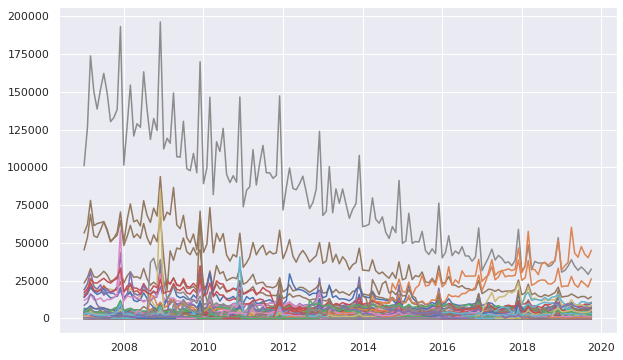

In [19]:
for i in frenchArt:
  plt.plot(frenchPivot[i,'Liter denne måned i år'])

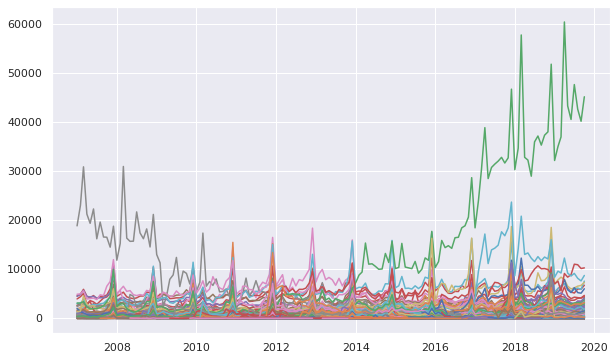

In [20]:
minPrice=0
maxPrice=10000
minAlkPris=0.0
maxAlkPris=0.5
minVolPris=0.0
maxVolPris=0.00629


for i in frenchArt:
  if frenchPivot[i,'Salgspris'][153]>minPrice and frenchPivot[i,'Salgspris'][153]<maxPrice:
    if frenchPivot[i,'Alk/Pris'][153]>minAlkPris and frenchPivot[i,'Alk/Pris'][153]<maxAlkPris:
      if frenchPivot[i,'Vol/Pris'][153]>minVolPris and frenchPivot[i,'Vol/Pris'][153]<maxVolPris:
        if i!=3339706 and i!=5024206: 
          plt.plot(frenchPivot[i,'Liter denne måned i år'])



Plots for project

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

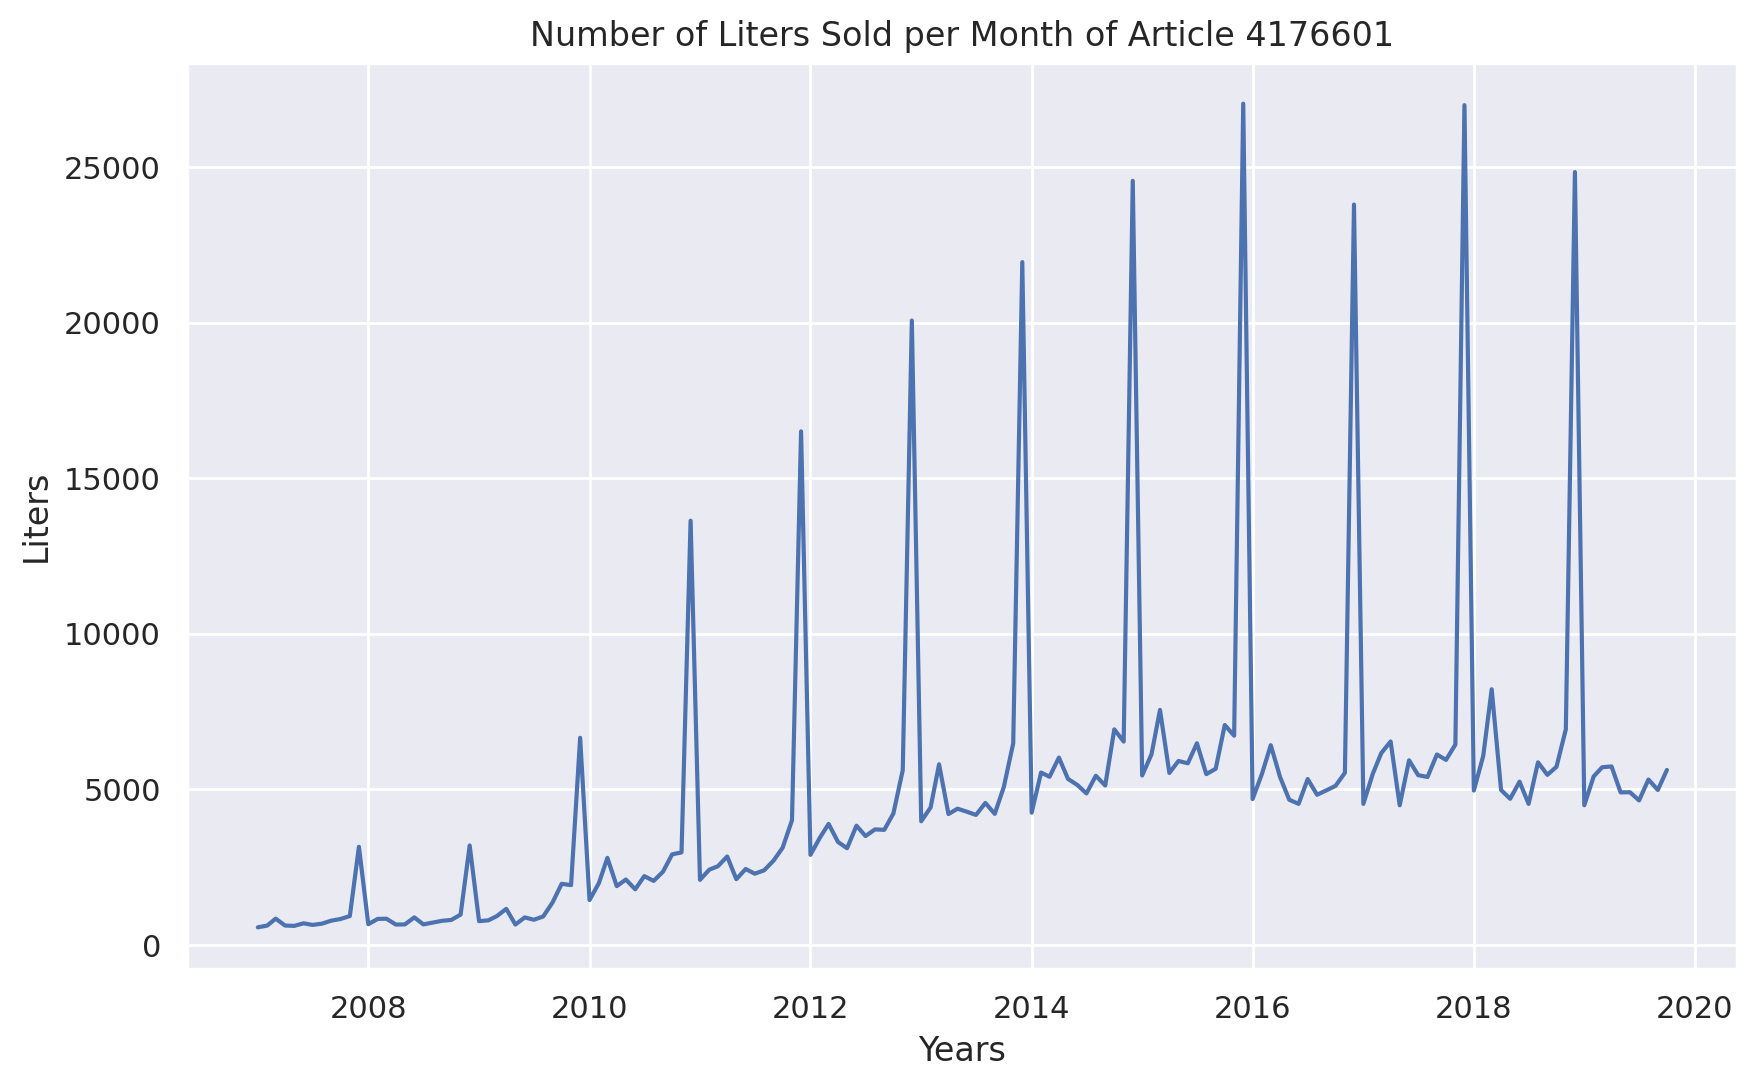

In [23]:
plt.figure(dpi=200)
plt.title('Number of Liters Sold per Month of Article 4176601')
plt.xlabel('Years')
plt.ylabel('Liters')
plt.plot(pivot[4176601,'Liter denne måned i år'])
plt.savefig("LitersExample.png")
files.download("LitersExample.png")

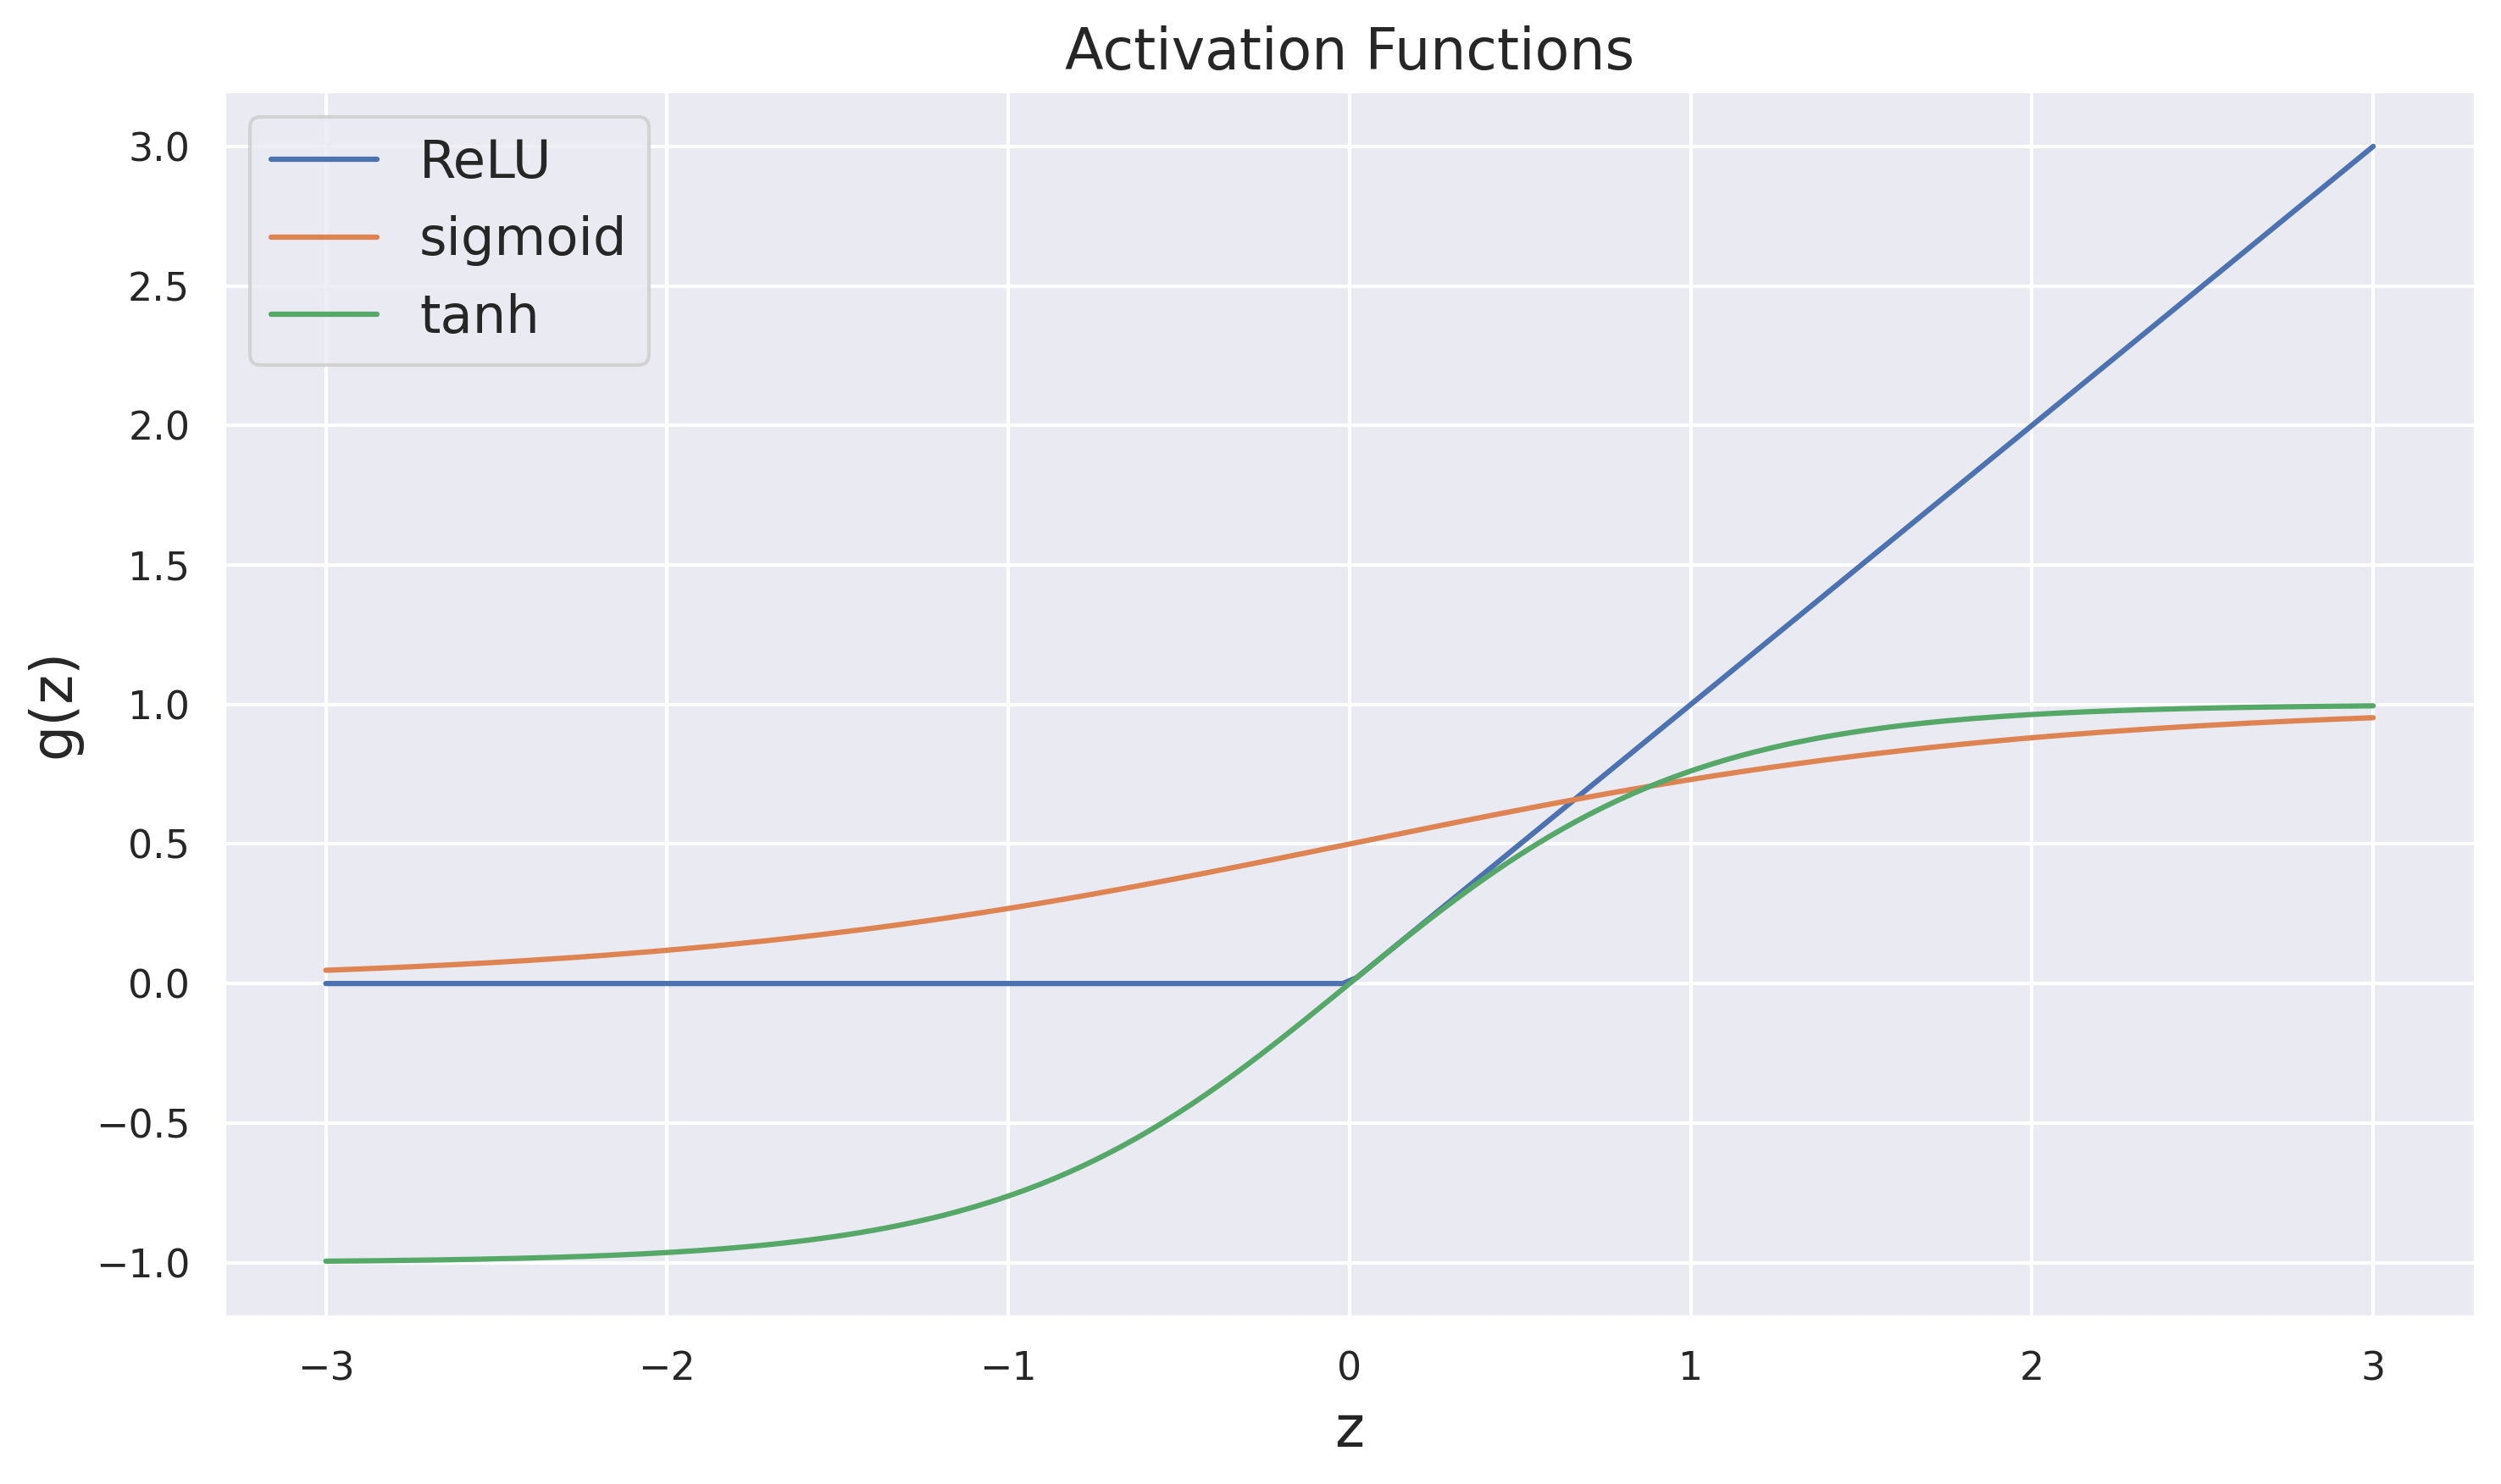

In [24]:
x=np.linspace(-3,3,150)

def ReLU(x):
  z=np.zeros(len(x))
  for i in range(len(x)):
    z[i]= max(x[i],0)
  return z

z=ReLU(x)

plt.figure(dpi=300)
plt.title('Activation Functions',size=16)
plt.xlabel('z',size=16)
plt.ylabel('g(z)',size=16)
plt.plot(x,z)
plt.plot(x,1 / (1 + np.exp(-x)))
plt.plot(x,np.tanh(x))
plt.legend(['ReLU', 'sigmoid', 'tanh'], loc='upper left', prop={'size': 15})
plt.tight_layout()
plt.savefig("activation_functions.png")